# Wilson et al. 2018

[Wilson, H., Niccolini, F., Pellicano, C., & Politis, M. (2019). Cortical thinning across Parkinson's disease stages and clinical correlates. Journal of the neurological sciences, 398, 31-38.](https://www.sciencedirect.com/science/article/pii/S0022510X19300206?casa_token=Kgrn-kkefGgAAAAA:s60jaJt1jTy_UEdyKRfuaoQDN5tF4DMoPa4gZW4m_2C3nC2DpLi5LgSuy9aiS3XdbPR3yh6HhA)

## Demographics

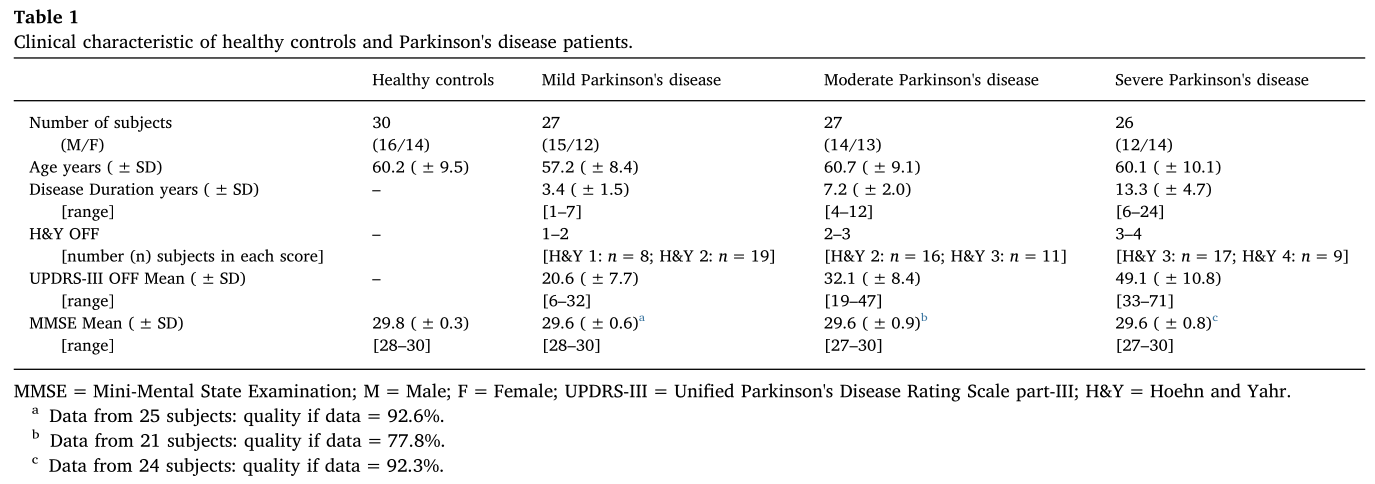

## Results

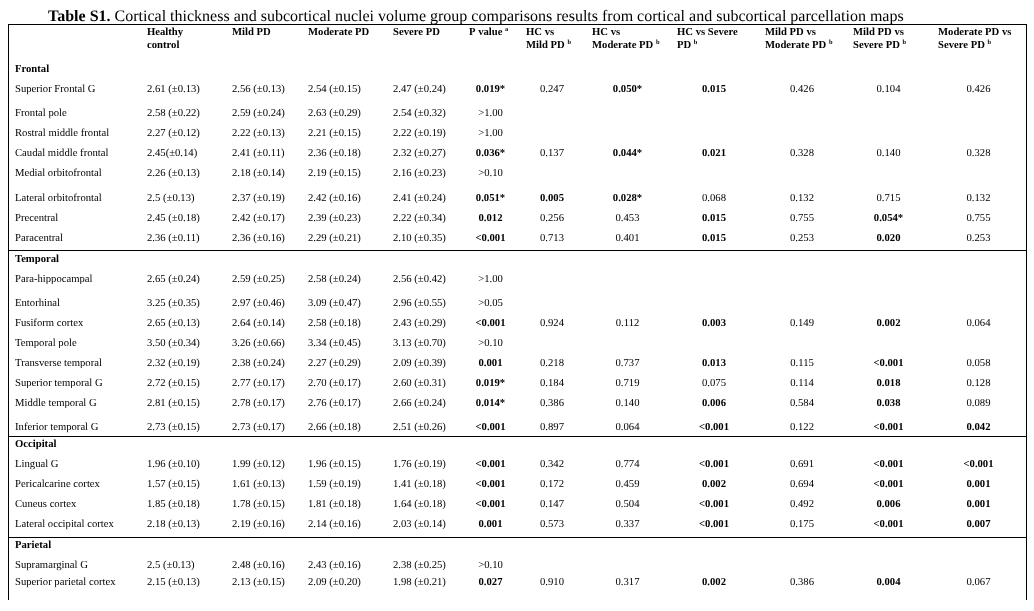
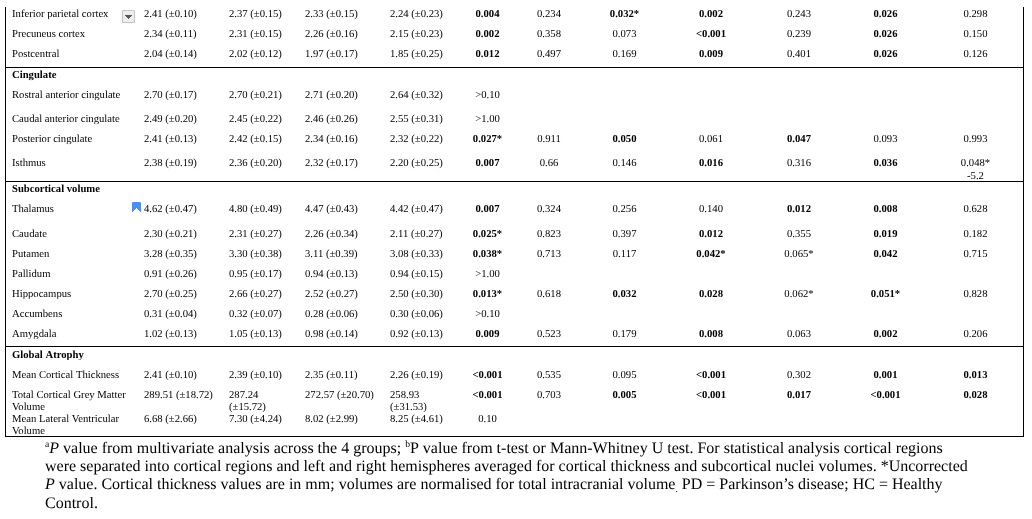

## Consistency analysis

In [1]:
import pandas as pd
from pathlib import Path
from IPython.display import Image

anonymizer = True

root_dir = Path().cwd().parent.parent.parent.parent.resolve()


def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
assert npv_dir.exists(), f"NPV dir does not exist: {anondir(npv_dir)}"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Wilson_2018"
print(f"Using data dir: {anondir(data_dir)}")
figure_dir = root_dir / "figures"
figure_dir.mkdir(parents=True, exist_ok=True)
assert figure_dir.exists(), f"Figure dir does not exist: {anondir(figure_dir)}"
print(f"Using figure dir: {anondir(figure_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/notebooks/papers_data/parkinson/Wilson_2018
Using figure dir: <living-park>/figures


### Load NPV maps

In [2]:
npv_subcortical_volume = pd.read_csv(npv_dir / "npv_hc-pd_baseline_subcortical_volume_bilateral.csv")
npv_thickness = pd.read_csv(npv_dir / "npv_hc-pd_baseline_thickness_bilateral.csv")

### Formula

In [3]:
import numpy as np
import scipy.stats

# T-test
def two_sample_t_value(m1, m2, s1, s2, n1, n2):
  return (m1 - m2) / np.sqrt(s1**2 / n1 + s2**2 / n2)
  
def std_t(npv):
  return npv

def std_p_t(t, df, npv):
  return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv

# F-test
def std_F(F, npv):
    return 2 * np.sqrt(F) * npv

def std_p_F(F, n, navr):
    return 2 * np.sqrt(F) * scipy.stats.f.pdf(F, dfn=1, dfd=n - 2) * navr

# Partial correlation
def std_r(r, n, npv):
  return ((1 - r**2)**3 / (n - 1))**0.5 * npv

def std_p_r(r, n, npv):
  t = r * ((n - 2) / (1 - r**2))**0.5
  return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt((n-2)/(n-1)) * npv



In [4]:
import pandas as pd
from scipy.stats import beta
import numpy as np

def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps) # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated

def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)   # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant
    
    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [5]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def plot_dumbbell(results, title):
    df = results.copy()
    df.rename(columns={"std_p": "std_p", "std_r": "std_r", "sig": "sig", "p": "p_value", "std_p_low": "std_p_low", "std_p_high": "std_p_high", "proba_significant": "psig"}, inplace=True)  
    df['std_p_low'] = df['std_p'] - df['std_p_low']
    df['std_p_high'] = df['std_p_high'] - df['std_p']
    
    col_label = "std_p"

    fig = make_subplots(rows=1, cols=3,  subplot_titles=["p-value", "std p-value", "Probability significance"])

    fig_1 = px.scatter(df, x='region', y='p_value', color="groups")
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x='region',
        y="std_p",
        color="groups",
        error_y='std_p_low',
        error_y_minus='std_p_high',
        labels="std_p"
    )
    fig_3 = go.Scatter(x=df['region'], y=df['psig'], mode='markers', marker_color='black', marker_symbol='cross', name="Flip probability", showlegend=False)

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3, rows=1, cols=3)

    fig.update_layout(
        title=title,
        yaxis_title=col_label,
        xaxis_title='Value',
        hovermode='closest',
        height=600,
        width=1400
    )

    fig.add_hline(y=0.05, line_color='red', line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

## Consistency analysis

### Table S1 - Cortical thickness and subcortical volume group comparisons

In [6]:
df = pd.read_csv(data_dir / "table_S1.csv")
df_thickness = df[df["metric"] == "cortical_thickness"]
df_thickness = pd.merge(df_thickness, npv_thickness, on="region")
df_thickness.drop(columns=["hemisphere", "num", "anat", "n", "timepoint"], inplace=True)
df_thickness.dropna(inplace=True)

n_hc = 30
n_mildpd = 27
n_modpd = 27
n_sevpd = 26
n_pd = n_mildpd + n_modpd + n_sevpd

n_map = {"HC": n_hc, "MildPD": n_mildpd, "ModPD": n_modpd, "SevPD": n_sevpd}

comparisons = ["HC_vs_MildPD", "HC_vs_ModPD", "HC_vs_SevPD", "MildPD_vs_ModPD", "MildPD_vs_SevPD", "ModPD_vs_SevPD"]

for comparison in comparisons: 
  group1,_,group2 = comparison.split("_")
  n1, n2 = n_map[group1], n_map[group2]
  df_thickness.rename(columns={comparison: comparison + "_p"}, inplace=True)
  m1,m2 = df_thickness[f'{group1}_mean'], df_thickness[f'{group2}_mean']
  sd1,sd2 = df_thickness[f'{group1}_sd'], df_thickness[f'{group2}_sd']
  df_thickness[comparison + "_sample_size"] = n1 + n2
  df_thickness[comparison + "_t"] = two_sample_t_value(m1, m2, sd1, sd2, n1, n2)
  df_thickness[comparison + "_std_p"] = std_p_t(df_thickness[comparison + "_t"], n1 + n2, df_thickness['npv'])
  df_thickness[comparison + "_std_p_low"] = std_p_t(df_thickness[comparison + "_t"], n1 + n2, df_thickness['npv_CI_low'])
  df_thickness[comparison + "_std_p_high"] = std_p_t(df_thickness[comparison + "_t"], n1 + n2, df_thickness['npv_CI_high'])
  df_thickness[comparison + "_proba_significant"] = flip_proba_beta(df_thickness[comparison + "_p"], df_thickness[comparison + "_std_p"])


df_thickness_sample_size = df_thickness[["region"] + df_thickness.columns[df_thickness.columns.str.endswith("sample_size")].tolist()]
df_thickness_sample_size.columns = ["region"] + [col.replace("_sample_size", "") for col in df_thickness_sample_size.columns[1:]]
df_thickness_sample_size = df_thickness_sample_size.melt(id_vars="region", var_name="groups", value_name="sample_size")

df_thickness_p = df_thickness[["region"] + df_thickness.columns[df_thickness.columns.str.endswith("D_p")].tolist()]
df_thickness_p.columns = ["region"] + [col.replace("_p", "") for col in df_thickness_p.columns[1:]]
df_thickness_p = df_thickness_p.melt(id_vars="region", var_name="groups", value_name="p")

df_thickness_std_p = df_thickness[["region"] + df_thickness.columns[df_thickness.columns.str.endswith("std_p")].tolist()]
df_thickness_std_p.columns = ["region"] + [col.replace("_std_p", "") for col in df_thickness_std_p.columns[1:]]
df_thickness_std_p = df_thickness_std_p.melt(id_vars="region", var_name="groups", value_name="std_p")

df_thickness_std_p_low = df_thickness[["region"] + df_thickness.columns[df_thickness.columns.str.endswith("std_p_low")].tolist()]
df_thickness_std_p_low.columns = ["region"] + [col.replace("_std_p_low", "") for col in df_thickness_std_p_low.columns[1:]]
df_thickness_std_p_low = df_thickness_std_p_low.melt(id_vars="region", var_name="groups", value_name="std_p_low")

df_thickness_std_p_high = df_thickness[["region"] + df_thickness.columns[df_thickness.columns.str.endswith("std_p_high")].tolist()]
df_thickness_std_p_high.columns = ["region"] + [col.replace("_std_p_high", "") for col in df_thickness_std_p_high.columns[1:]]
df_thickness_std_p_high = df_thickness_std_p_high.melt(id_vars="region", var_name="groups", value_name="std_p_high")


df_thickness_flip = df_thickness[["region"] + df_thickness.columns[df_thickness.columns.str.endswith("proba_significant")].tolist()]
df_thickness_flip.columns = ["region"] + [col.replace("_proba_significant", "") for col in df_thickness_flip.columns[1:]]
df_thickness_flip = df_thickness_flip.melt(id_vars="region", var_name="groups", value_name="proba_significant")

df_thickness = (pd.merge(df_thickness_p, df_thickness_std_p, on=["region", "groups"])
  .merge(df_thickness_sample_size, on=["region", "groups"])
  .merge(df_thickness_flip, on=["region", "groups"])
  .merge(df_thickness_std_p_low, on=["region", "groups"])
  .merge(df_thickness_std_p_high, on=["region", "groups"])
)

df_thickness.rename(columns={"p": "p_value"}, inplace=True)
df_thickness["alpha"] = 0.05
df_thickness["significant"] = df_thickness["p_value"] < df_thickness["alpha"]
df_thickness["metric"] = "cortical thickness"
df_thickness["test"] = "T"

In [7]:
plot_dumbbell(df_thickness, "Cortical thickness")

In [8]:
df = pd.read_csv(data_dir / "table_S1.csv")
df_sv  = df[df["metric"] == "subcortical_volume"]
df_sv = pd.merge(df_sv, npv_subcortical_volume, on="region")
df_sv.drop(columns=["num", "anat", "n", "timepoint"], inplace=True)
df_sv.dropna(inplace=True)

n_hc = 30
n_mildpd = 27
n_modpd = 27
n_sevpd = 26
n_pd = n_mildpd + n_modpd + n_sevpd

n_map = {"HC": n_hc, "MildPD": n_mildpd, "ModPD": n_modpd, "SevPD": n_sevpd}

comparisons = ["HC_vs_MildPD", "HC_vs_ModPD", "HC_vs_SevPD", "MildPD_vs_ModPD", "MildPD_vs_SevPD", "ModPD_vs_SevPD"]

for comparison in comparisons: 
  group1,_,group2 = comparison.split("_")
  n1,n2 = n_map[group1], n_map[group2]
  df_sv.rename(columns={comparison: comparison + "_p"}, inplace=True)
  m1,m2 = df_sv[f'{group1}_mean'], df_sv[f'{group2}_mean']
  sd1,sd2 = df_sv[f'{group1}_sd'], df_sv[f'{group2}_sd']
  df_sv[comparison + "_sample_size"] = n1 + n2
  df_sv[comparison + "_t"] = two_sample_t_value(m1, m2, sd1, sd2, n1, n2)
  df_sv[comparison + "_std_p"] = std_p_t(df_sv[comparison + "_t"], n1 + n2, df_sv['npv'])
  df_sv[comparison + "_std_p_low"] = std_p_t(df_sv[comparison + "_t"], n1 + n2, df_sv['npv_CI_low'])
  df_sv[comparison + "_std_p_high"] = std_p_t(df_sv[comparison + "_t"], n1 + n2, df_sv['npv_CI_high'])
  df_sv[comparison + "_proba_significant"] = flip_proba_beta(df_sv[comparison + "_p"], df_sv[comparison + "_std_p"])

df_sv_sample_size = df_sv[["region"] + df_sv.columns[df_sv.columns.str.endswith("sample_size")].tolist()]
df_sv_sample_size.columns = ["region"] + [col.replace("_sample_size", "") for col in df_sv_sample_size.columns[1:]]
df_sv_sample_size = df_sv_sample_size.melt(id_vars="region", var_name="groups", value_name="sample_size")

df_sv_p = df_sv[["region"] + df_sv.columns[df_sv.columns.str.endswith("D_p")].tolist()]
df_sv_p.columns = ["region"] + [col.replace("_p", "") for col in df_sv_p.columns[1:]]
df_sv_p = df_sv_p.melt(id_vars="region", var_name="groups", value_name="p")

df_sv_std_p = df_sv[["region"] + df_sv.columns[df_sv.columns.str.endswith("std_p")].tolist()]
df_sv_std_p.columns = ["region"] + [col.replace("_std_p", "") for col in df_sv_std_p.columns[1:]]
df_sv_std_p = df_sv_std_p.melt(id_vars="region", var_name="groups", value_name="std_p")

df_sv_std_p_low = df_sv[["region"] + df_sv.columns[df_sv.columns.str.endswith("std_p_low")].tolist()]
df_sv_std_p_low.columns = ["region"] + [col.replace("_std_p_low", "") for col in df_sv_std_p_low.columns[1:]]
df_sv_std_p_low = df_sv_std_p_low.melt(id_vars="region", var_name="groups", value_name="std_p_low")

df_sv_std_p_high = df_sv[["region"] + df_sv.columns[df_sv.columns.str.endswith("std_p_high")].tolist()]
df_sv_std_p_high.columns = ["region"] + [col.replace("_std_p_high", "") for col in df_sv_std_p_high.columns[1:]]
df_sv_std_p_high = df_sv_std_p_high.melt(id_vars="region", var_name="groups", value_name="std_p_high")


df_sv_flip = df_sv[["region"] + df_sv.columns[df_sv.columns.str.endswith("proba_significant")].tolist()]
df_sv_flip.columns = ["region"] + [col.replace("_proba_significant", "") for col in df_sv_flip.columns[1:]]
df_sv_flip = df_sv_flip.melt(id_vars="region", var_name="groups", value_name="proba_significant")

df_sv = (pd.merge(df_sv_p, df_sv_std_p, on=["region", "groups"])
  .merge(df_sv_sample_size, on=["region", "groups"])
  .merge(df_sv_flip, on=["region", "groups"])
  .merge(df_sv_std_p_low, on=["region", "groups"])
  .merge(df_sv_std_p_high, on=["region", "groups"])
  )

df_sv.rename(columns={"p": "p_value"}, inplace=True)
df_sv["alpha"] = 0.05
df_sv["test"] = "T"
df_sv["metric"] = "subcortical volume"
df_sv["significant"] = df_sv["p_value"] < df_sv["alpha"]

In [9]:
plot_dumbbell(df_sv, "Subcortical volume")

In [10]:
df = pd.concat([df_thickness, df_sv])
df["study"] = "cross-sectional"
# Assert dataframe contains "proba_significant" and "significant" columns
assert "p_value" in df.columns
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
assert "study" in df.columns
df.to_csv(data_dir / "uncertainty.csv", index=False)